### Introduction

A very important property that needs to be estimated when using Structure Based Models (SBMs) is the folding temperature. In order to study a physical change with molecular simulations we need to focus the sampling over the region of interest in the potential energy surface. When studying protein folding this can be achieved by setting the folding free energy to zero, which happens when the system has no preference of being in either the folded or unfolded state (i.e. it visits the two states with equal probability during the simulation). One way of achieving this is by rising the temperature until we observe the above property at the obtained emsemble. However, an indirect and easier way of estimating the folding temperature is by noting that the heat capacity has a maximum at this temperature. Thus, by estimating the heat capacity in a range of temperatures around the folding temperature we can easily estimate its value.

The heat capacity is related to the variations in the potential energy (V) by:

$Cv = \frac{\partial V}{\partial T}$

This value can be estimated from an ensemble of simulated states with:

$Cv = \frac{ \langle V^2 \rangle -  \langle V \rangle^2}{k_BT^2}$

Where, $ \langle X \rangle $ means an ensemble-averaged value of the property X, $k_B$ is the Boltzmann constant and T the temperature of the simulation.

In this tutorial we employ the WHAM method using the PyWham program to improve and facilitate the estimation of the heat capacity values in a more thorough theoretical framework.

### Requirements 

- [OpenMM python API](http://openmm.org/)
- [sbmOpenMM library](https://bitbucket.org/compbiochbiophlab/sbm-openmm/src)
- [Numpy](https://numpy.org/)
- [Matplotlib](https://matplotlib.org/)
- [PyWham](http://pywham.net/)

### Estimating the folding temperature using the CA model

In this tutorial we will estimate the folding temperature of a small protein system using the CA model. First, we will run several short simulations at different temperatures to estimate roughly the location of the folding temperature. After this we focus the sampling in this region to have a better estimate. We start by loading OpenMM and the sbmOpenMM library:

In [1]:
#Import OpenMM library
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *

#Import sbmOpenMM library
import sbmOpenMM

We load the input pdb and the contact file for our system:

In [2]:
#Set the input locations as variables.
pdb_file = 'inputs/1YPA_I.pdb'
contact_file = 'inputs/1YPA_I_CA.contacts'

We create the SBM CA model object:

In [3]:
#Create an sbmOpenMM.system() object and store it in "sbmCAModelModel" variable. 
sbmCAModel = sbmOpenMM.models.getCAModel(pdb_file, contact_file)

Generating CA SBM for structure file inputs/1YPA_I.pdb

Setting up geometrical parameters:
_________________________________
Keeping only alpha carbon atoms in topology
Added 64 CA atoms
Added 63 bonds
Added 62 angles
Added 61 torsions
Reading contacts from contact file: inputs/1YPA_I_CA.contacts
Added 164 native contacts

Setting up default forcefield parameters:
________________________________________
Adding default bond parameters:
Adding default angle parameters:
Adding default torsion parameters:
Adding default contact parameters:
Adding default excluded volume parameters:

Adding Forces:
_____________
Added Harmonic Bond Forces
Added Harmonic Angle Forces
Added Periodic Torsion Forces
Added Lennard Jones 12-10 Forces to native contacts
Added Lennard Jones 12 non-bonded Forces

Creating System Object:
______________________
The Potential Energy of the system is : -163.62130737304688 kJ/mol
The Harmonic Bond Energy is: 1.4299672557172016e-09 kj/mol
The Harmonic Angle Energy is: 3.

Let's now generate a for loop to run several simulations at different temperatures. In each iteration we will redefine the integrator and simulation context to set up, each time, a simulation from the same starting coordinates. We also change the name of the energy file to be written so we can store them and read them later for analysis. We span the range between 100 and 200 RTU with a step of 5 RTU. 

In [4]:
import time

#Iterate over the temeperature range of interest.
for temperature in range(100,201,5):
    
    #Define the name of the energy file for each temperature
    energy_file = 'energy_'+str(temperature)+'_rough.data'
    
    #Define the integrator and context for the simulation at the defined temperature
    integrator = LangevinIntegrator(temperature, 1/picosecond, 0.5*femtoseconds)
    simulation = Simulation(sbmCAModel.topology, sbmCAModel.system, integrator)
    
    #Set the initial coordinates
    simulation.context.setPositions(sbmCAModel.positions)
    
    #Add a SBM reporter that writes energies every 1 picosecond = 2000 steps (at 0.5 fs timestep).
    simulation.reporters.append(sbmOpenMM.sbmReporter(energy_file, 2000, sbmObject=sbmCAModel,
                                                  step=True, potentialEnergy=True, temperature=True))
        
    #Run each simulation for 1 ns = 2 million steps.
    start_time = time.time()
    simulation.step(2000000)
    print("--- Finished simlation at T=%s in %s seconds ---" % (temperature, (time.time() - start_time)))

--- Finished simlation at T=100 in 34.39399075508118 seconds ---
--- Finished simlation at T=105 in 34.468079566955566 seconds ---
--- Finished simlation at T=110 in 33.722252368927 seconds ---
--- Finished simlation at T=115 in 34.91812872886658 seconds ---
--- Finished simlation at T=120 in 34.38662338256836 seconds ---
--- Finished simlation at T=125 in 36.2786021232605 seconds ---
--- Finished simlation at T=130 in 41.2440071105957 seconds ---
--- Finished simlation at T=135 in 34.93944597244263 seconds ---
--- Finished simlation at T=140 in 34.71672010421753 seconds ---
--- Finished simlation at T=145 in 34.97697138786316 seconds ---
--- Finished simlation at T=150 in 34.87726163864136 seconds ---
--- Finished simlation at T=155 in 34.88491201400757 seconds ---
--- Finished simlation at T=160 in 34.74556374549866 seconds ---
--- Finished simlation at T=165 in 35.1294059753418 seconds ---
--- Finished simlation at T=170 in 34.76057815551758 seconds ---
--- Finished simlation at T=1

In order to analyse the simulations we need to read each energy file created above and extract the potential energy from it. To facilitate this we write a function that reads the comma-separated-value energy file into a dictionary that contains all the energy values as numpy arrays.

In [5]:
import numpy as np

def readOpenMMReporterFile(reporter_file):
    #Open the reporter file
    with open(reporter_file, 'r') as ef:
        #Store the lines 
        lines = ef.readlines()
        #Define a dictionary to store the data
        data = {}
        #read the header and create for each term an entry for the dictionary initialised to a list
        for r in lines[0].split(','):
            data[r.replace('#','').replace('"','').strip()] = []
        #read each value in the file and store it in the dictionary's lists.
        for i,r in enumerate(data):
            for line in lines[1:]:
                #Convert the read string into a float for easy processing of numerical data
                data[r].append(float(line.strip().split(',')[i]))
                
        #Convert each list into a numpy array
        for entry in data:
            data[entry] = np.array(data[entry])
            
    #return the created dictionary
    return data

First, we take a peek at the returned dictionary from the previous function to understand how to call the energy values. It contains all the values of each energy term in the energy file as numpy arrays. To see the name of the keys of the dictionary we load an arbitrary file with the function and then we print its keys:

In [6]:
#Read an arbitrary energy file with the function readOpenMMReporterFile
simulationData = readOpenMMReporterFile('energy_100_rough.data')
#Print the keys of the returned dictionary
print(simulationData.keys())

dict_keys(['Step', 'Potential Energy (kJ/mole)', 'Temperature (K)', 'Harmonic Bond Energy (kJ/mol)', 'Harmonic Angle Energy (kJ/mol)', 'Periodic Torsion Energy (kJ/mol)', 'LJ 12-10 Contact Energy (kJ/mol)', 'LJ 12 Repulsion Energy (kJ/mol)'])


We see that the potential energy can be called from the dictionary by using the string 'Potential Energy (kJ/mole)'. We can now read all the simulated files and plot the energy progress of each trajectory to have an idea of how the simulations are behaving.

In [7]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Potential Energy (kJ/mole)')

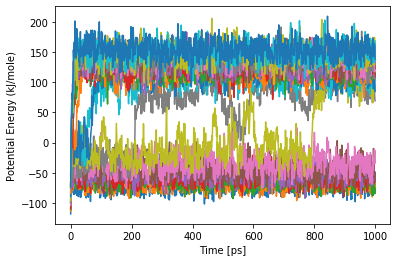

In [8]:
#Iterate over the temeperature range of interest.
for temperature in range(100,201,5):
    
    #Define the name of the energy file for each temperature
    energy_file = 'energy_'+str(temperature)+'_rough.data'
    
    #Read the energy data from each energy file
    simulationData = readOpenMMReporterFile(energy_file)
    
    #For easy reading we store the potential energy numpy array into a variable
    V = simulationData['Potential Energy (kJ/mole)']
    
    #Plot the potential energy
    plt.plot(V)

plt.xlabel('Time [ps]')
plt.ylabel('Potential Energy (kJ/mole)')

We observe a discontinuity in the potential energy plots. We see roughly two populations of simulations, one at high (actually positive) values of potential energy and the other one at low (or negative) values. We expect this two populations to be correlated with the temperatures of the simulations. To confirm this we are going to repeat our plot but using a color gradient to plot each temperature. We import colors and cm (color maps) from matplotlib to create our color palette.

In [9]:
import matplotlib.colors as mcol
import matplotlib.cm as cm

#Create a color range from blue to red for the explored temperatures.
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName", ["b","r"])
cnorm = mcol.Normalize(vmin=100, vmax=200)
cpick = cm.ScalarMappable(norm=cnorm, cmap=cm1)
cpick.set_array([])

We repeat the plot using a gradient that is going from cold (blue) to hot (red) simulations. 

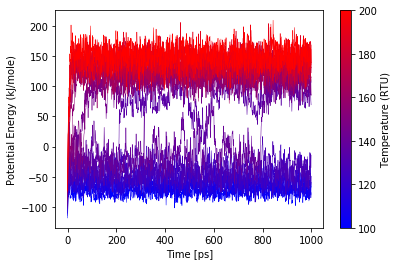

In [10]:
#Iterate over the temeperature range of interest.
for temperature in range(100,201,5):
    
    #Define the name of the energy file for each temperature
    energy_file = 'energy_'+str(temperature)+'_rough.data'
    
    #Read the energy data from each energy file
    simulationData = readOpenMMReporterFile(energy_file)
    
    #For easy reading we store the potential energy numpy array into a variable
    V = simulationData['Potential Energy (kJ/mole)']
    
    #Plot the potential energy using the previously defined color gradient
    #We also diminish the thickness of the plotted lines to better visualization
    plt.plot(V, color=cpick.to_rgba(temperature), lw=0.5)

#Add labels to the plot
plt.xlabel('Time [ps]')
plt.ylabel('Potential Energy (kJ/mole)')

#Add a colorbar to the plot
plt.colorbar(cpick,label="Temperature (RTU)")

Now is more clear that the two groups correspond to high and low temperature simulations. This happens because most of the potential energy change comes from the rupture of native contacts (highly negative term in the force field), and, at the folding temperature, this happens abruptly and cooperatively, hence the discontinuity in the potential energy plot.

This plot aids us into see that we are spanning a range contaiining the folding temperature for the protein system. We expect it to be below 150 RTU given that we have some blue plots in the high temperature population. To have a more quantitative estimation of the unfolding temperature we will plot the heat capacity as a function of the simulated temeperature.

To facilitate the calculation of the heat capacity and other relevant quantities from the SBM simulations, we are going to employ the PyWham program. PyWham is a flexible implementation of the Weighted Histogram Analysis Method ([WHAM](https://onlinelibrary.wiley.com/doi/abs/10.1002/jcc.540130812)) implemented in Python 2, that can be executed thorugh the command line as a separate program. 

First, we need to create the files with the correct format to be read by PyWham. In this case we are only concerned with the heat capacity, which can be obtained from the potential energy only. We write the potential energy values for each simulated temperature as separated files in a folder we name 'heatCapacityData'. We use numpy to write the potential energy arrays as columns into the output files.

In [11]:
import os

#Create the output folder if it does not exists
folderName = 'heatCapacityData'
if not os.path.exists(folderName):
    os.mkdir(folderName)
    
#Iterate over the temeperature range of interest.
for temperature in range(100,201,5):
    
    #Define the name of the energy file for each temperature
    energy_file = 'energy_'+str(temperature)+'_rough.data'
    
    #Read the energy data from each energy file
    simulationData = readOpenMMReporterFile(energy_file)
    
    #For easy reading we store the potential energy numpy array into a variable
    V = simulationData['Potential Energy (kJ/mole)']
    
    #We define the path name of the outputfile
    fileName = folderName+'/'+str(temperature)+'_rough.data'
    
    #Save the potential energies into a file using numpy.savetxt method
    np.savetxt(fileName, V, newline="\n")

PyWham uses an xml file to specify any calculation to be carried out. An example input file, 'pywham_hc_rough_estimate.xml', is stored in the input folder. The file includes all the paths to the files generated by our procedure. For more information about how to set up and execute PyWham please read the [PyWham manual](http://pywham.net/documentation/index.html).

A note of caution: PyWham uses pyhton2, so please be sure that you are using the correct python interpreter to execute the program.

The ouput file from PyWham heat capacity calculation is called 'pywham_hc_rough_estimate.out'. The file contains just two columns; the temeperature and the heat capacity. We use matlplotlib to plot the calculated values:

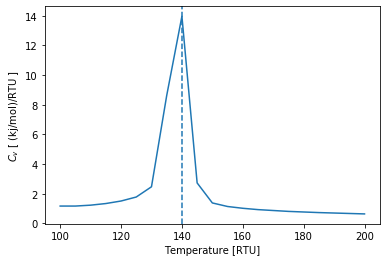

In [12]:
#Create lists to store the calculated values.
temperature = []
heat_capacity = []

#Read the PyWham heat capacity output file
with open('pywham_hc_rough_estimate.out', 'r') as hcf:
    
    #Iterate over the lines and store the values
    for line in hcf:
        ls = line.strip().split()            #line splitted by columns
        temperature.append(float(ls[0]))     #column 1
        heat_capacity.append(float(ls[1]))   #column 2
        
#Plot the heat capacity dependence on temperature
plt.plot(temperature, heat_capacity)
plt.xlabel('Temperature [RTU]')
plt.ylabel('$C_v$ [ (kj/mol)/RTU ]')
plt.axvline(140, ls='--')

The estimate above is a bit rough for our purpose, a better estimate will come by increasing the simulation time and decreasing the step size in the temperature range. With the above result we now focus on exploring nearby a temperature of 140 RTU. We explore the system every one degree and, this time, using 10 ns of simulation time.

In [13]:
#Iterate over the temeperature range of interest.
for temperature in range(135,145+1):
    
    #Define the name of the energy file for each temperature
    energy_file = 'energy_'+str(temperature)+'.data'
    
    #Define the integrator and context for the simulation at the defined temperature
    integrator = LangevinIntegrator(temperature, 1/picosecond, 0.5*femtoseconds)
    simulation = Simulation(sbmCAModel.topology, sbmCAModel.system, integrator)
    
    #Set the initial coordinates
    simulation.context.setPositions(sbmCAModel.positions)
    
    #Add a SBM reporter that writes energies every 1 picosecond = 2000 steps (at 0.5 fs timestep).
    simulation.reporters.append(sbmOpenMM.sbmReporter(energy_file, 2000, sbmObject=sbmCAModel,
                                                  step=True, potentialEnergy=True, temperature=True))
        
    #Run each simulation for 10 ns = 20 million steps.
    start_time = time.time()
    simulation.step(20000000)
    print("--- Finished simlation at T=%s in %s seconds ---" % (temperature, (time.time() - start_time)))

--- Finished simlation at T=135 in 347.9999420642853 seconds ---
--- Finished simlation at T=136 in 355.16577672958374 seconds ---
--- Finished simlation at T=137 in 359.14502024650574 seconds ---
--- Finished simlation at T=138 in 347.5701410770416 seconds ---
--- Finished simlation at T=139 in 340.125785112381 seconds ---
--- Finished simlation at T=140 in 339.24187660217285 seconds ---
--- Finished simlation at T=141 in 340.2134988307953 seconds ---
--- Finished simlation at T=142 in 339.2568120956421 seconds ---
--- Finished simlation at T=143 in 340.2339344024658 seconds ---
--- Finished simlation at T=144 in 340.3950996398926 seconds ---
--- Finished simlation at T=145 in 339.29068207740784 seconds ---


We write again the PyWahm input files using the newly created energy files. We run PyWham using the input script in the inputs folder: 'pywham_hc_better_estimate.xml'

In [14]:
#Create a list to store the paths of the output files
output_files = []

#Create the output folder if it does not exists
folderName = 'heatCapacityData'
if not os.path.exists(folderName):
    os.mkdir(folderName)
    
#Iterate over the temeperature range of interest.
for temperature in range(135,145+1):
    
    #Define the name of the energy file for each temperature
    energy_file = 'energy_'+str(temperature)+'.data'
    
    #Read the energy data from each energy file
    simulationData = readOpenMMReporterFile(energy_file)
    
    #For easy reading we store the potential energy numpy array into a variable
    V = simulationData['Potential Energy (kJ/mole)']
    
    #We define the path name of the outputfile
    fileName = folderName+'/'+str(temperature)+'.data'
    
    #Save the potential energies into a file using numpy.savetxt method
    np.savetxt(fileName, V, newline="\n")
    
    output_files.append(fileName)

Finally we plot the newly estimated heat capacity plot from the output simulation. 

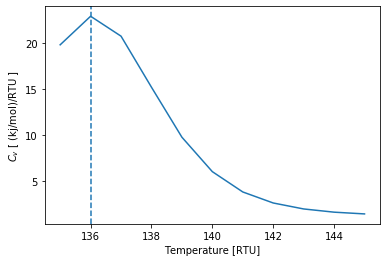

In [15]:
#Create list to store the calculated values.
temperature = []
heat_capacity = []

#Read the PyWham heat capacity output file
with open('pywham_hc_better_estimate.out', 'r') as hcf:
    #Iterate over the lines and store the values
    for line in hcf:
        ls = line.strip().split()
        temperature.append(float(ls[0]))
        heat_capacity.append(float(ls[1]))

#Plot the heat capacity dependence on temperature
plt.plot(temperature, heat_capacity)
plt.xlabel('Temperature [RTU]')
plt.ylabel('$C_v$ [ (kj/mol)/RTU ]')
plt.axvline(136, ls='--')

We see a shift of 4 degrees in the estimated folding temperature, but we can expect this estimate to be better than the previous one.

Finally, we are going to plot how the prediction of the folding temperature depends on the length of the simulation. For this we use the 10ns simulations and we run PyWham using incresing simulation data. Iteratively, we are going to write data files each with extra 1 ns-data points. From these we generate 10 plots of heat capacity vs temperature and plot them using a color gradient representing the incresing simulation time.

In [16]:
#Create a list to store the paths of the output files
output_files = {}
for i in range(10):
    output_files[i] = []
        
#Create the output folder if it does not exists
folderName = 'iterativeHeatCapacityData'
if not os.path.exists(folderName):
    os.mkdir(folderName)
    
#Iterate over the temeperature range of interest.
for temperature in range(135,145+1):
    
    #Define the name of the energy file for each temperature
    energy_file = 'energy_'+str(temperature)+'.data'
    
    #Read the energy data from each energy file
    simulationData = readOpenMMReporterFile(energy_file)
    
    #Second interation to trim the data every 1ns extra each iteration
    for i in range(10):
        
        #Slice the energy numpy array using 1000 frames = 1000 ps = 1 ns extras each iteration.
        V = simulationData['Potential Energy (kJ/mole)'][:1000*(i+1)]
    
        #We define the path name of the outputfile
        fileName = folderName+'/energy_'+str(temperature)+'_time_'+str(i+1).zfill(2)+'.data'
    
        #Save the potential energies into a file using numpy.savetxt method
        np.savetxt(fileName, V, newline="\n")
    
        output_files[i].append(fileName)

Now we need to execute PyWham iteratively for each set of input files generated. To assist this in the 'inputs' folder there is 10 script, 'pywham_iterative_"$iteration_number".xml', that reads the corresponding set of input files. After generating the PyWham output files we proceede to plot them:

In [17]:
#Create a color range from blue to red for the iteration range.
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName", ["b","r"])
cnorm = mcol.Normalize(vmin=1, vmax=10)
cpick = cm.ScalarMappable(norm=cnorm, cmap=cm1)
cpick.set_array([])

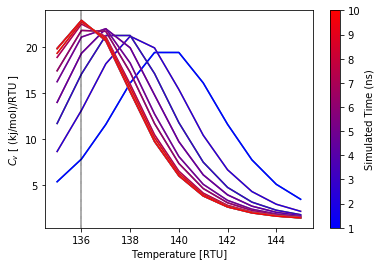

In [18]:
for i in range(10):
    #Create list to store the calculated values.
    temperature = []
    heat_capacity = []

    #Read the iterative PyWham heat capacity output file
    with open('pywham_iterative_'+str(i+1).zfill(2)+'.out', 'r') as hcf:
        #Iterate over the lines and store the values
        for line in hcf:
            ls = line.strip().split()
            temperature.append(float(ls[0]))
            heat_capacity.append(float(ls[1]))

    plt.plot(temperature, heat_capacity)
    #Plot the heat capacity dependence on temperature using the previously defined color gradient
    plt.plot(temperature,heat_capacity, color=cpick.to_rgba(i+1))
    
    #Add labels
    plt.xlabel('Temperature [RTU]')
    plt.ylabel('$C_v$ [ (kj/mol)/RTU ]')
    plt.axvline(136, ls='--', color='k', lw=0.1)

#Add a colorbar to the plot
plt.colorbar(cpick,label="Simulated Time (ns)")

For the studied system we see that the prediction of the folding temperature convergences around 7 ns of simulated time. This gives us confidence that the 10 ns of simulation was enough for giving a reasonable estimate of the folding temperature at short simulation times. 

### Summary

In this tutorial we focused on estimating the folding temperature by looking at the maximum value of the heat capacity vs temperature plot. We first did a rough estimate to locate the range of values where to focus the search for the folding temperature. A more thorough simulation revealed that the first estimation was off by 3 degrees. The procedure was applied using a coarse grained forcefield, but it should be generalized to any forcefield derived data.